# Práctico 02: Análisis Exploratorio y Curación

In [ ]:
import numpy as np
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Definimos algunas funciones que vamos a usar

def to_categorical(column, bin_size=10, min_cut=15, max_cut=65):
    if min_cut is None:
        min_cut = int(round(column.min())) - 1
    value_max = int(np.ceil(column.max()))
    max_cut = min(max_cut, value_max)
    intervals = [(x, x + bin_size) for x in np.arange(min_cut, max_cut, bin_size)]
    if max_cut != value_max:
        intervals.append((max_cut, value_max))
    return pd.cut(column, pd.IntervalIndex.from_tuples(intervals))

In [ ]:
def rescale(df,column,tcolumn):
  min = np.min(df[column])
  max = np.max(df[column])
  scaled_col = tcolumn*(max-min) + min
  return scaled_col

In [ ]:
def to_numerical(df,column,tcolumn):
  l = list(df[df[column].notna()][column].unique())
  df.loc[df[column].isna(),tcolumn] = np.nan
  for i,item in enumerate(l):
    # if len(df[df[column] == item]) > 0:
    # print(i+1,item)
    df.loc[df[column] == item,tcolumn] = i+1  

In [ ]:
def restore_category(df,column,tcolumn):
  l = list(df[df[column].notna()][column].unique())
  n = list(df[tcolumn].unique())
  for number in n:
    print(number,l[number-1])
    df.loc[df[tcolumn] == number, column] = l[number-1]
  # for i,item in enumerate(l):
      # df.loc[df[tcolumn] == n, column] = item


In [ ]:
# Opción para ver todas las columnas del dataset en el notebook
pd.set_option('display.max_columns', 50)

## Objetivo del práctico

### Verificar variable por variable
- Distribución
- Valores nulos
- Cardinalidad y distribución
- Outliers
- Fechas
- Correlaciones
- Otros aspectos...

### Modificar el dataset aplicando transformaciones

Una vez verificadas las variables tenemos que realizar transformaciones para que podamos utilizarlas en el futuro.
- ¿Existen valores nulos? ¿Qué alternativas podrían realizarse?
- ¿Existen outliers? ¿Qué podemos hacer con los outliers?
- Debemos encodear los valores nulos correctamente, no deberíamos tener observaciones con valores como -99.
- No cambiemos el nombre de las variables, pero sí podríamos cambiar los atributos si es necesario.
- ¿Todas las variables son necesarias? ¿Deberíamos eliminar alguna columna?
- ¿Existen variable correlacionadas? ¿Qué podemos hacer con éstas variables?


### Presentación

Al final del práctico, es necesario hacer 1 o 2 slides que irán incluidos en la presentación final.  
Los slides deberán contener las principales transformaciones que realizamos en el dataset.  
Además será necesario realizar el primer video con la explicación de los prácticos 1 y 2.

### Librerías recomendadas

Sólo usaremos la librería "pandas". Recomiendo el siguiente material:  
- https://jakevdp.github.io/PythonDataScienceHandbook/ -> Muy buen libro con explicaciones claras de cómo funciona lo básico de pandas (cap. 3)
- https://pandas.pydata.org/docs/index.html -> Referencia de pandas, para buscar funciones, ejemplos, etc.

## **Resolución**

### Leer el dataset

In [ ]:
# Leemos el dataset con la función de pandas "read_csv"
url = "https://raw.githubusercontent.com/AgusCarchano/Mentorias-grupo1/master/data/bank-additional-full.csv"
df = pd.read_csv(url, sep=";")

Para poder continuar trabajando con nuestros datos, haremos la limpieza de los mismos, verificando cardinalidad, nulos, dispersiones, etc. Si es necesario, realizaremos agrupaciones y transformaciones.

### Análisis de las variables

El análisis de cada una de las variables fue expuesto en la notebook de Análisis de datos. No obstante, algunos puntos serán explorados en mayor profundidad aquí.

#### Valores nulos

In [ ]:
df.isna().sum()    #conteo de valores NaN

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Si bien las variables de la base de datos no presentan datos nulos o NaN, durante el análisis de datos se advirtió que existen observaciones con ciertos valores y/0 codificaciones para las variables que habría que revisar. 

Por ejemplo, las observaciones que se agrupan en "desconocido" dentro de las variables categóricas, las observaciones que cuentan con un valor igual a "999" para la variable pdays (por no haber sido contactadas previamente), las observaciones "nonexistent" de poutcome, y los registros donde duration = 0, que deberían ser tratados de manera especial, de alguna manera, ya que por defecto esos registros tienen y = 'no', y en realidad no son estrictamente un caso de "fracaso".

Primeramente, buscamos insconsistencias en los datos, basándonos en pdays = 999

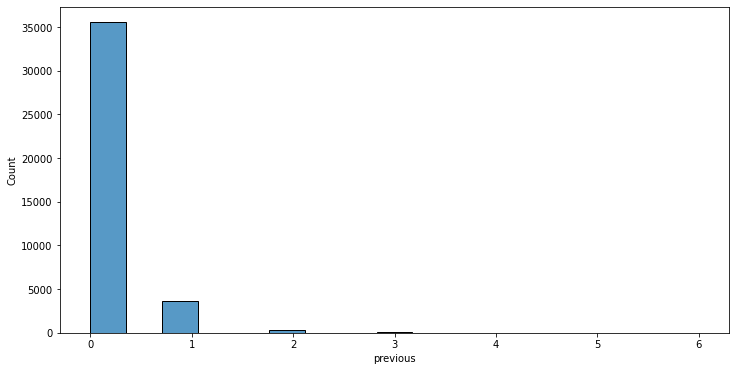

In [ ]:
#previous calls para aquellas observaciones que indicarían que nunca fueron contactados anteriormente
plt.figure(figsize=(12,6))
sns.histplot(data=df[df.pdays == 999],x="previous")
plt.show()

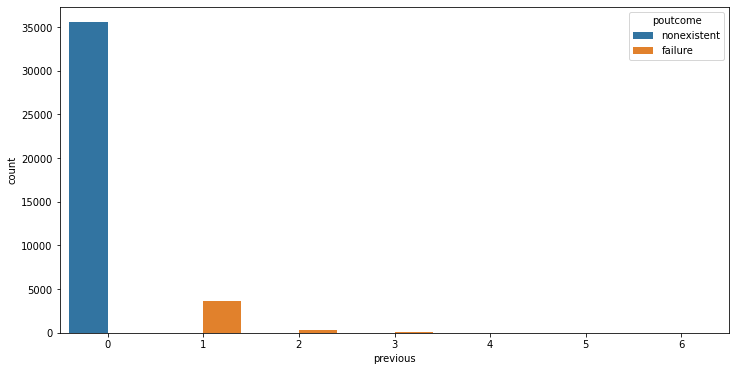

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=df[df.pdays == 999],x="previous", hue = "poutcome")
plt.show()

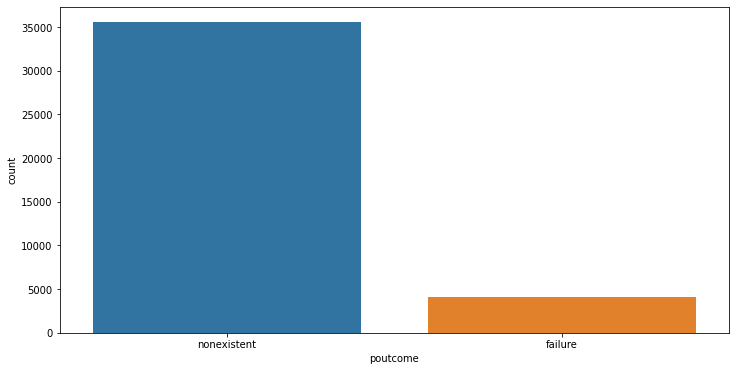

In [ ]:
#poutcome
plt.figure(figsize=(12,6))
sns.countplot(data=df[df.pdays == 999],x="poutcome")
plt.show()

Hay un subonjunto de clientes que tienen cargado en pdays el valor 999 (indicativo de que no fue contactado previamente en campañas anteriores), pero que, sin embargo, indican que fueron contactados más de una vez antes de esta campaña (variable previous) y fueron categorizados como casos de "Failure" en para la variable poutcome. Esto nos lleva a concluir que **existe una inconsistencia en los datos**.

In [ ]:
#cantidad de casos inconsistentes
inconsist_poutcome=len(df[(df.pdays == 999) & (df.poutcome == 'failure')])
inconsist_previous=len(df[(df.pdays == 999) & (df.previous > 0)])
inconsist_poutcome==inconsist_previous


True

In [ ]:
inconsist_poutcome

4110

Estos 4.110 registros representan un dato faltante o missing para la variable pdays, y podría ser relevante realizar alguna imputación que los diferencie del resto de los casos para los cuales pdays es igual a 999 (que representarían correctamente a los casos en que el cliente no fue contactado previamente).


In [ ]:
print("% casos inconsistentes sobre el total: ", inconsist_poutcome/len(df)*100, "%")

% casos inconsistentes sobre el total:  9.97863455375352 %


#### Outliers

En el análisis preliminar realizado para el práctico 1 se detectaron outliers en 2 de las variables numéricas: duration y campaign. A continuación, un análisis más detallado de esto.

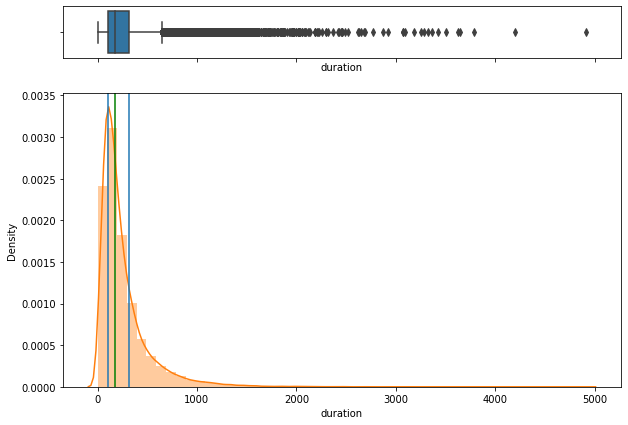

Duración promedio= 4.304750169952413  minutos
Duración Máxima= 81.96666666666667  minutos
Duración Máxima= 4918  segundos
Duración Mínima= 0  segundos


In [ ]:
#Outliers en la variable duration
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,7),gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(df.duration, ax=ax_box)
sns.distplot(df.duration, ax=ax_hist, kde=False, hist=False)
sns.distplot(df.duration, ax=ax_hist, kde=True, hist=True,norm_hist=False)
plt.axvline(df.duration.quantile(0.25))
plt.axvline(df.duration.quantile(0.50),color='g')
plt.axvline(df.duration.quantile(0.75))
plt.ticklabel_format(style='plain', axis='x') 
plt.show()


print("Duración promedio=", df.duration.mean()/60, " minutos")
print("Duración Máxima=", df.duration.max()/60, " minutos")
print("Duración Máxima=", df.duration.max(), " segundos")
print("Duración Mínima=", df.duration.min(), " segundos")

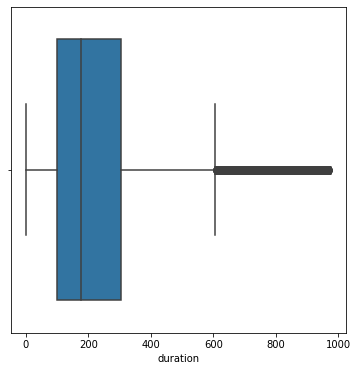

In [ ]:
#Filtramos por el percentil 97.5
plt.figure(figsize=(6,6))
sns.boxplot(df.duration[df.duration <=df.duration.quantile(0.975) ])
plt.show()

In [ ]:
q975_duration=df.duration.quantile(0.975)
q975_duration

975.0

En las referencias del dataset se indica como una nota que: duration es un atributo que afecta altamente al resultado, ya que si la duración de la llamada fue 0, la respuesta entonces fue negativa (el cliente no contrató el PF). Luego de la llamada, el resultado es conocido con certeza. 

Por tanto, esta variable solo debería incluirse para análisis preliminares y **debería ser descartada si la intención es obtener un modelo predictivo realístico**. 

In [ ]:
len(df[df.duration == 0])

4

Solamente hay 4 casos para los cuales duration = 0

Percentil 97.5:  10.0


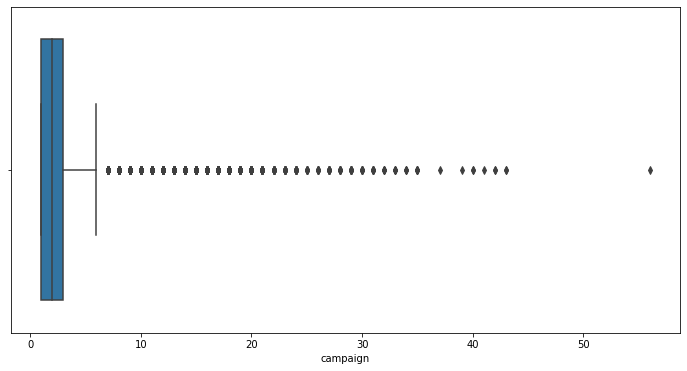

In [ ]:
#outliers en la variable campaign
plt.figure(figsize=(12,6))
sns.boxplot(data=df,x="campaign")
print("Percentil 97.5: ",df.campaign.quantile(.975))          #el 97.5% de las personas fueron contactadas menos de 10 veces

Percentil 97.5:  10.0


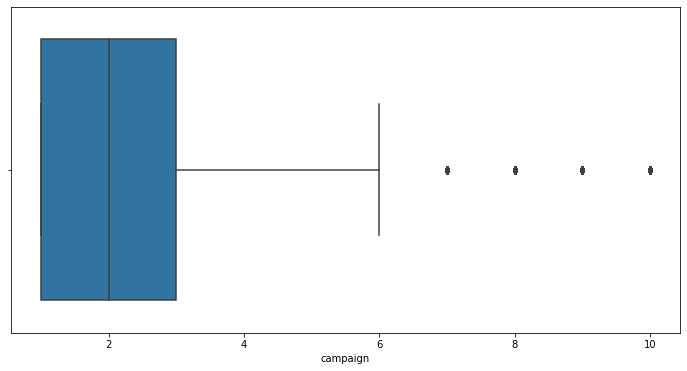

In [ ]:
#Hacemos el boxplot filtrando por x<= 10
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df['campaign']<=10],x="campaign")
print("Percentil 97.5: ",df.campaign.quantile(.975))

In [ ]:
q975_campaign=df.campaign.quantile(0.975)
q975_campaign

10.0

En ambos casos, podríamos optar por eliminar a los valores que son mayores o iguales al quantil 97,5.

#### Distribuciones de las variables numéricas

En el Práctico 1 se expuso un análisis detallado de las distribuciones de variables numéricas. En lo que aquí continúa, se agregará el análisis de las variables de "fecha".

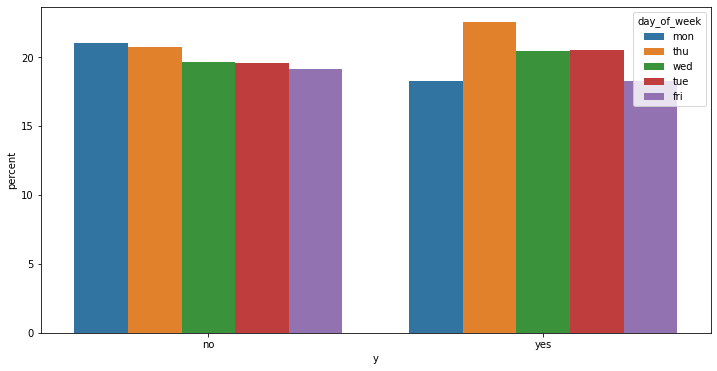

In [ ]:
#Si graficamos porcentajes lo vemos aún mas claro, no hay un patrón claro en Yes o en No
x,y = 'y','day_of_week'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x,y='percent',hue=y,data=df1)
plt.show()

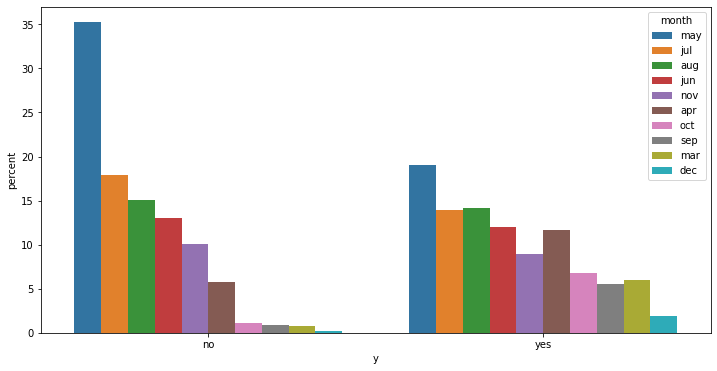

In [ ]:
#Si graficamos porcentajes lo vemos aún mas claro, no hay un patrón claro en Yes o en No
x,y = 'y','month'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x,y='percent',hue=y,data=df1)
plt.show()

**Dado que no aporta información muy relevante, consideramos que esta variable podría ser eliminada del dataset luego de realizar las imputaciones por los datos faltantes**

#### Cardinalidad de las variables categóricas

En el práctico 1 se analizaron en detalle las variables categóricas, y se propusieron reagrupamientos para reducir la cardinalidad de las mismas. Retomaremos estos reagrupamientos luego de realizadas las imputaciones, para las variables que sea considerado necesario.

#### Correlación entre variables

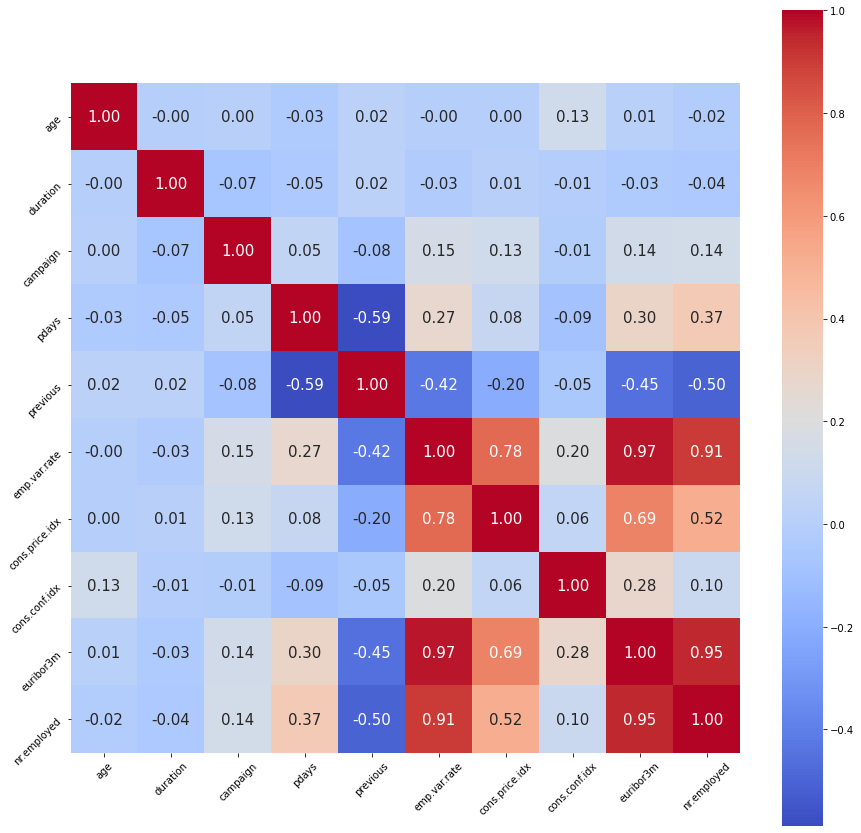

In [ ]:
# Recomiendo usar el heatmap de seaborn: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df.corr()  #Debido a que las variables no poseen distribución normal se utilizó el metodo de spearman, poner "spearman"
plt.figure(figsize=(15,15))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

Se advierte la presencia de una alta correlación entre las variables nr.employed y emp.var.rate con euribor3m, variable representativa de la tasa de interés.
También se advierte una correlación alta entre cons.price.idx y emp.var.rate, así como también con la variable euribor3m.

#### Otros análisis

Vamos a realizar un análisis de componentes principales (PCA) de las variables numéricas, con el propósito de identificar las variables o características que aportan más información, reduciendo así la dimensionalidad del dataset.

Para esto, necesitaremos contar con una versión de la base de datos en que todas las variables tengan la misma escala. 

Se hará el análisis de componentes principales luego de efectuadas las imputaciones sobre los valores NaN de las variables.


### Tratamiento y modificación de las variables

Creamos una copia del DF para trabajar con las modificaciones

In [ ]:
bank_df = df.copy(deep=True)

#### Outliers

Primeramente, se eliminan los valores outliers detectados para las variables Campaign. 

La variable Duration no será tomada en consideración para la realización de modelos predictivos, con lo cual, no se eliminarán los datos outliers de esta variables. 

In [ ]:
#Campaign
bank_df.drop(bank_df[bank_df.campaign >= q975_campaign].index, inplace = True)

In [ ]:
bank_df.shape, df.shape     #se redujo dataset en menos del 3% luego de eliminar los outliera

((40094, 21), (41188, 21))

#### Valores nulos

Vamos a analizar e imputar los valores nulos, o categorías "desconocido" de las variables.

In [ ]:
# Porcentaje de datos faltantes menor al 1%
job_desconocido=len(bank_df[bank_df["job"]=="unknown"])
print("% de casos desconocido: ", job_desconocido/len(bank_df)*100,"%")

% de casos desconocido:  0.7956302688681598 %


In [ ]:
# Porcentaje de datos faltantes menor al 1%
marital_desconocido=len(bank_df[bank_df["marital"]=="unknown"])
print("% de casos desconocido: ", marital_desconocido/len(bank_df)*100,"%")

% de casos desconocido:  0.1870604080411034 %


In [ ]:
# Porcentaje de datos faltantes menor al 5%
education_desconocido=len(bank_df[bank_df["education"]=="unknown"])
print("% de casos desconocido: ", education_desconocido/len(bank_df)*100,"%")

% de casos desconocido:  4.185164862572954 %


In [ ]:
default_desconocido=len(bank_df[bank_df["default"]=="unknown"])
housing_desconocido=len(bank_df[bank_df["housing"]=="unknown"])
loan_desconocido=len(bank_df[bank_df["loan"]=="unknown"])
print("default: % de casos desconocido: ", default_desconocido/len(bank_df)*100,"%")
print("housing: % de casos desconocido: ", housing_desconocido/len(bank_df)*100,"%")
print("loan: % de casos desconocido: ", loan_desconocido/len(bank_df)*100,"%")

default: % de casos desconocido:  20.743752182371427 %
housing: % de casos desconocido:  2.3993615004738866 %
loan: % de casos desconocido:  2.3993615004738866 %


El porcentaje de casos desconcidos para las variables crediticias es menor al 3%, salvo para la variable default cuyo porcentaje supera el 20% de los casos.

In [ ]:
# Porcentaje de datos faltantes alrededor del 10% 
   #(mayor que el calculado anteriormente, porque eliminamos observaciones de la base de datos)
pdays_desconocido = len(bank_df[(bank_df.pdays == 999) & (bank_df.poutcome != 'nonexistent')])
print("pdays: % de casos desconocido: ", pdays_desconocido/len(bank_df)*100,"%")

pdays: % de casos desconocido:  10.218486556592008 %


In [ ]:
pdays_desconocido = len(bank_df[(bank_df.pdays == 999) & (bank_df.poutcome != 'nonexistent')])
pdays_conocido = len(bank_df[bank_df.pdays != 999])
print("pdays - % para imputar: ", pdays_desconocido/(pdays_conocido+pdays_desconocido)*100,"%")

pdays - % para imputar:  73.03030303030303 %


Se debería imputar un valor de pdays para el 73% de los casos que debieran tener un valor efectivamente. **Son demasiados valores, asi que optaremos por eliminar esta variable.**

Para proceder a la imputación, primero codificamos las filas con "unknown" como NaN

In [ ]:
bank_df.loc[bank_df.marital=='unknown','marital']= np.nan
bank_df.loc[bank_df.education=='unknown','education']= np.nan
bank_df.loc[bank_df.job=='unknown','job']= np.nan
bank_df.loc[bank_df.default=='unknown','default']= np.nan
bank_df.loc[bank_df.housing=='unknown','housing']= np.nan
bank_df.loc[bank_df.loan=='unknown','loan']= np.nan

Pasamos a numericas estas variables categóricas para poder imputarlas con KNN más facilmente

In [ ]:
bank_df['job_num'] = 0
bank_df['marital_num'] = 0
bank_df['education_num'] = 0
bank_df['loan_num'] = 0
bank_df['housing_num'] = 0
bank_df['default_num'] = 0

to_numerical(bank_df, 'job', 'job_num')
to_numerical(bank_df, 'marital', 'marital_num')
to_numerical(bank_df, 'education', 'education_num')
to_numerical(bank_df, 'loan', 'loan_num')
to_numerical(bank_df, 'housing', 'housing_num')
to_numerical(bank_df, 'default', 'default_num')

In [ ]:
bank_df.education_num.unique()

array([ 1.,  2.,  3.,  4.,  5., nan,  6.,  7.])

Seleccionamos columnas para utilizar en la imputación. Pdays no la incluimos: Tiene muchos valores "nulos" (999) que son correctos, porque el cliente no habia sido contactado previamente, pero no nos ayudarán para la imputación.

In [ ]:
bank_df.isna().sum()    #conteo de valores NaN

age                  0
job                319
marital             75
education         1678
default           8317
housing            962
loan               962
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
job_num            319
marital_num         75
education_num     1678
loan_num           962
housing_num        962
default_num       8317
dtype: int64

In [ ]:
columnas_cat = ['contact', 'month', 'day_of_week','poutcome','y']

columnas_num = ['age','duration', 'campaign',
       'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed','education_num', 'marital_num','job_num','loan_num','housing_num','default_num']

Usamos DictVectorizer para encodear solo las variables categóricas

In [ ]:
feature_dict = list(bank_df[columnas_cat + columnas_num].T.to_dict().values())

In [ ]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False)
feature_matrix = vec.fit_transform(feature_dict)

In [ ]:
feature_matrix.shape

(40094, 37)

##### Imputación por KNN

Es necesario escalar las columnas numéricas antes de imputar por KNN

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled = scaler.fit_transform(feature_matrix)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

In [ ]:
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(),n_nearest_features=5)
scaled_mice = mice_imputer.fit_transform(scaled)

Posiciones de las variables imputadas en la matriz scaled_mice:

default_num: columna 11  
education_num: columna 13  
housing_num: columna 16  
job_num: columna 17  
loan_num: columna 18  
marital_num: columna 19

In [ ]:
feature_dict[0]

{'age': 56,
 'campaign': 1,
 'cons.conf.idx': -36.4,
 'cons.price.idx': 93.994,
 'contact': 'telephone',
 'day_of_week': 'mon',
 'default_num': 1.0,
 'duration': 261,
 'education_num': 1.0,
 'emp.var.rate': 1.1,
 'euribor3m': 4.857,
 'housing_num': 1.0,
 'job_num': 1.0,
 'loan_num': 1.0,
 'marital_num': 1.0,
 'month': 'may',
 'nr.employed': 5191.0,
 'poutcome': 'nonexistent',
 'previous': 0,
 'y': 'no'}

Paso las columnas imputadas a la escala original

In [ ]:
education_num_imp = rescale(bank_df,'education_num',scaled_mice[:,13])
education_num_imp = np.around(education_num_imp).astype(int)

marital_num_imp = rescale(bank_df,'marital_num',scaled_mice[:,19])
marital_num_imp = np.around(marital_num_imp).astype(int)

default_num_imp = rescale(bank_df,'default_num',scaled_mice[:,11])
default_num_imp = np.around(default_num_imp).astype(int)

housing_num_imp = rescale(bank_df,'housing_num',scaled_mice[:,16])
housing_num_imp = np.around(housing_num_imp).astype(int)

loan_num_imp = rescale(bank_df,'loan_num',scaled_mice[:,18])
loan_num_imp = np.around(loan_num_imp).astype(int)

job_num_imp = rescale(bank_df,'job_num',scaled_mice[:,17])
job_num_imp = np.around(job_num_imp).astype(int)


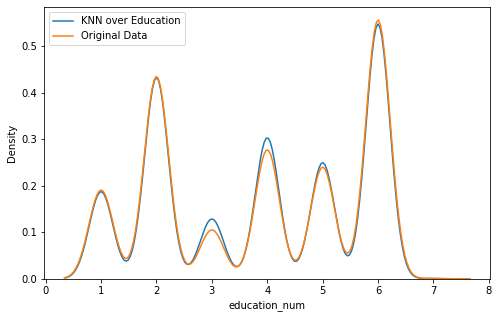

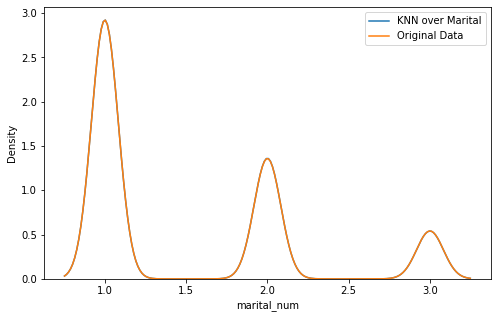

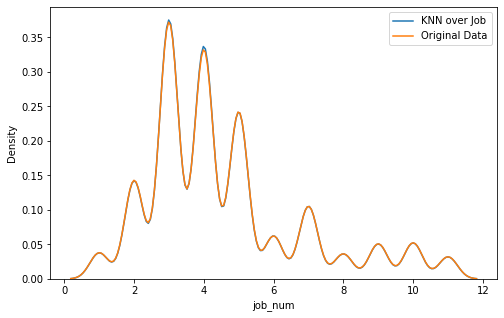

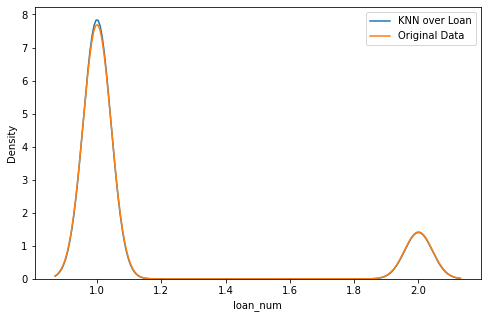

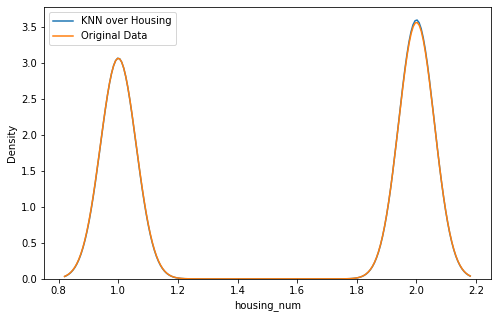

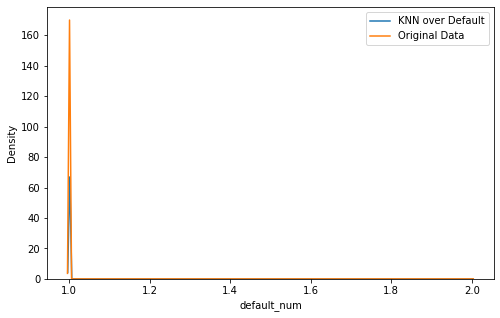

In [ ]:
fig = plt.figure(figsize=(8, 5))
sns.kdeplot(data=education_num_imp,label = 'KNN over Education')
sns.kdeplot(data=bank_df.education_num,label = 'Original Data')
plt.legend()
plt.show()

fig = plt.figure(figsize=(8, 5))
sns.kdeplot(data=marital_num_imp,label = 'KNN over Marital')
sns.kdeplot(data=bank_df.marital_num,label = 'Original Data')
plt.legend()
plt.show()

fig = plt.figure(figsize=(8, 5))
sns.kdeplot(data=job_num_imp,label = 'KNN over Job')
sns.kdeplot(data=bank_df.job_num,label = 'Original Data')
plt.legend()
plt.show()

fig = plt.figure(figsize=(8, 5))
sns.kdeplot(data=loan_num_imp,label = 'KNN over Loan')
sns.kdeplot(data=bank_df.loan_num,label = 'Original Data')
plt.legend()
plt.show()

fig = plt.figure(figsize=(8, 5))
sns.kdeplot(data=housing_num_imp,label = 'KNN over Housing')
sns.kdeplot(data=bank_df.housing_num,label = 'Original Data')
plt.legend()
plt.show()

fig = plt.figure(figsize=(8, 5))
sns.kdeplot(data=default_num_imp,label = 'KNN over Default')
sns.kdeplot(data=bank_df.default_num,label = 'Original Data')
plt.legend()
plt.show()

Cargamos los valores imputados a nuestro DF original

In [ ]:
bank_df['education_num'] = education_num_imp
bank_df['marital_num'] = marital_num_imp
bank_df['loan_num'] = loan_num_imp
bank_df['housing_num'] = housing_num_imp
bank_df['default_num'] = default_num_imp
bank_df['job_num'] = job_num_imp

In [ ]:
bank_df_2 = bank_df.copy(deep=True)

Reestablecemos las categorías originales de las variables.

In [ ]:
restore_category(bank_df_2,  'education', 'education_num')

1 basic.4y
2 high.school
3 basic.6y
4 basic.9y
5 professional.course
6 university.degree
7 illiterate


In [ ]:
restore_category(bank_df_2,  'marital', 'marital_num')

1 married
2 single
3 divorced


In [ ]:
restore_category(bank_df_2,  'loan', 'loan_num')

1 no
2 yes


In [ ]:
restore_category(bank_df_2,  'housing', 'housing_num')

1 no
2 yes


In [ ]:
restore_category(bank_df_2,  'default', 'default_num')

1 no
2 yes


In [ ]:
restore_category(bank_df_2,  'job', 'job_num')

1 housemaid
2 services
3 admin.
4 blue-collar
5 technician
6 retired
7 management
8 unemployed
9 self-employed
10 entrepreneur
11 student


In [ ]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_num,marital_num,education_num,loan_num,housing_num,default_num
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,1,1,1,1,1
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,1,2,1,1,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,1,2,1,2,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3,1,3,1,1,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,1,2,2,1,1


In [ ]:
bank_df_2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_num,marital_num,education_num,loan_num,housing_num,default_num
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,1,1,1,1,1
1,57,services,married,high.school,no,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,1,2,1,1,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,1,2,1,2,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3,1,3,1,1,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,1,2,2,1,1


In [ ]:
bank_df_2.isna().sum()    #conteo de valores NaN

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
job_num           0
marital_num       0
education_num     0
loan_num          0
housing_num       0
default_num       0
dtype: int64

Para la imputación de los NaN de la variable pdays, podríamos plantear la imputación de los casos dejando fuera del análisis a aquellos cuyo valor es 999. Esto sería, hacer la imputación sobre una versión reducida del dataset. No obstante, el porcentaje de casos a imputar es muy grande en relación al total de casos para los cuales esa variable podría tener un valor relevante, con los cual, se decidió eliminarla del dataset.

In [ ]:
#eliminar las variables que quedaron repetidas y  pdays
bank_df_2=bank_df_2.drop(['job_num', 'marital_num', 'education_num','loan_num','housing_num','default_num','pdays' ], axis=1)

In [ ]:
#Guardamos esto para tener de BackUp, y no volver a tener que correr todo
bank_df_2.to_csv('bank_df_2.csv', index=False)

In [ ]:
from google.colab import files
files.download('bank_df_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Distribuciones de las variables numéricas

#### Cardinalidad de las variables categóricas

Vamos a retomar aquí los reagrupamientos de categorías que fueron propuestos en el Práctico 1, ahora sin considerar la categoría "desconocido" ya que la misma fue imputada.

In [ ]:
#reagrupar las categorías de job 
bank_df_2['job_groups'] = bank_df_2['job'].map({'housemaid': 'Sin ingreso Propio',
                                  'student': 'Sin ingreso Propio',
                                  'unemployed': 'Sin ingreso Propio',
                                  'services': 'Servicios',
                                  'admin.': 'Administrtivos',
                                  'retired': 'Ingreso Cuenta Propia o Directivo',
                                  'self-employed': 'Ingreso Cuenta Propia o Directivo',
                                  'entrepreneur': 'Ingreso Cuenta Propia o Directivo',
                                  'management': 'Ingreso Cuenta Propia o Directivo',
                                  'technician': 'Tecnicos',
                                  'blue-collar': 'Operarios' }
                                            )

In [ ]:
#reagrupar las categorías de la variable educación
bank_df_2['education_groups'] = bank_df_2['education'].map({'illiterate': 'Basic or less',
                                              'basic.4y': 'Basic or less',
                                               'basic.6y': 'Basic or less',
                                                'basic.9y': 'Basic or less',
                                                  'high.school': 'High School',
                                                   'professional.course': 'Professional',
                                                    'university.degree': 'University'}
                                            )

In [ ]:
#valores de las variables crediticias
bank_df_2.default.unique(), bank_df_2.housing.unique(), bank_df_2.loan.unique()

(array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object))

In [ ]:
#recodificación de las variables crediticias
bank_df_2.default.replace(to_replace=["yes","no"],value=[1,0],inplace=True)
bank_df_2.loan.replace(to_replace=["yes","no"],value=[1,0],inplace=True)
bank_df_2.housing.replace(to_replace=["yes","no"],value=[1,0],inplace=True)

#### Correlación entre variables

Debido a la alta correlación existente entre algunas de las variables de contexto, se definió eliminar a las siguientes:
- nr.employed
- emp.var.rate
- cons.price.idx

In [ ]:
# Eliminamos las variables que se encuentran muy correlacionadas
bank_df_2=bank_df_2.drop(['nr.employed', 'emp.var.rate','cons.price.idx'], axis=1)

#### Otras transformaciones - PCA

Como se mencionó anteriormente, se realiza un Análisis de Componentes Principales sobre las variables numéricas. 

In [ ]:
# Leemos el dataset que guardamos como backup con la función de pandas "read_csv"
from google.colab import files
uploaded = files.upload()

In [ ]:
file_key = 'bank_df_2.csv'  
df2 = pd.read_csv(io.StringIO(uploaded[file_key].decode('utf-8')))

In [ ]:
# df2 = bank_df_2.copy(deep=True)

In [ ]:
df2.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
       'poutcome', 'cons.conf.idx', 'euribor3m', 'y', 'job_groups',
       'education_groups'],
      dtype='object')

In [ ]:
column_num=["age","duration","campaign","previous","cons.conf.idx","euribor3m"]

In [ ]:
#MinMax o StandardScaler?
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
scaler=MinMaxScaler()
#scaler= StandardScaler()

df2[column_num]=scaler.fit_transform(df2[column_num])

In [ ]:
df2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,cons.conf.idx,euribor3m,y,job_groups,education_groups
0,0.481481,housemaid,married,basic.4y,0,0,0,telephone,may,mon,0.053070,0.0,0.0,nonexistent,0.60251,0.957379,no,Sin ingreso Propio,Basic or less
1,0.493827,services,married,high.school,0,0,0,telephone,may,mon,0.030297,0.0,0.0,nonexistent,0.60251,0.957379,no,Servicios,High School
2,0.246914,services,married,high.school,0,1,0,telephone,may,mon,0.045954,0.0,0.0,nonexistent,0.60251,0.957379,no,Servicios,High School
3,0.283951,admin.,married,basic.6y,0,0,0,telephone,may,mon,0.030704,0.0,0.0,nonexistent,0.60251,0.957379,no,Administrtivos,Basic or less
4,0.481481,services,married,high.school,0,0,1,telephone,may,mon,0.062424,0.0,0.0,nonexistent,0.60251,0.957379,no,Servicios,High School


Hacemos el Análisis de Componente Principales (PCA) trabajando solo sobre las variables numéricas


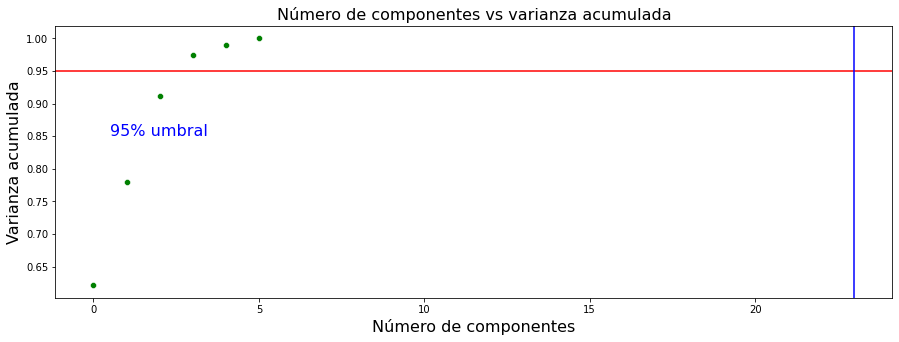

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(df2[column_num])


y = np.cumsum(pca.explained_variance_ratio_) #acomulado
x = np.arange(0, len(y), step=1)



plt.figure(figsize=(15,5))
sns.scatterplot(x, y, linestyle='-', color='g')

plt.xlabel('Número de componentes',fontsize=16)
plt.ylabel('Varianza acumulada',fontsize=16)
plt.title('Número de componentes vs varianza acumulada',fontsize=16)

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=23, color='b', linestyle='-')
plt.text(0.5, 0.85, '95% umbral', color = 'b', fontsize=16)

plt.show()

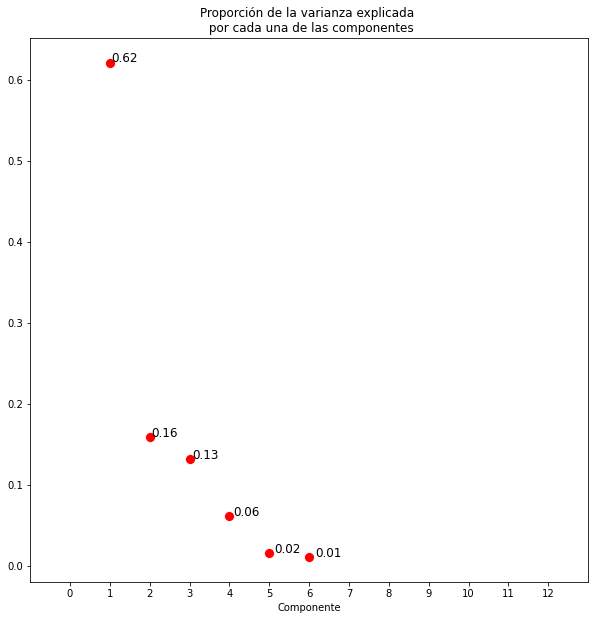

In [ ]:
import warnings
warnings.filterwarnings('ignore')
varianzas = pca.explained_variance_ratio_

plt.figure(figsize=(10,10))
x = np.arange(len(column_num))+1
sns.scatterplot(x=x, y = varianzas, s = 100, color = 'red')
plt.xlim(-1,13)
plt.xticks(np.arange(0,13))
plt.xlabel("Componente")
plt.title("Proporción de la varianza explicada \n por cada una de las componentes")
for i,varianza in enumerate(varianzas):
	plt.annotate(f'{varianza:3.2f}', (x[i],varianzas[i]), fontsize = 12,textcoords='offset points')
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([0.62131562, 0.15928978, 0.13144059, 0.06189213, 0.01537718,
       0.0106847 ])

Agregamos las tres primeras componentes bank_df_2

In [ ]:
proyected_features = pca.transform(df2[column_num])

bank_df_2['pca1'] = proyected_features[:,0]
bank_df_2['pca2'] = proyected_features[:,1]
bank_df_2['pca3'] = proyected_features[:,2]

In [ ]:
#eliminamos la variable duration, ya que no nos servirá para predecir Y
bank_df_2=bank_df_2.drop(['duration'], axis=1)

In [ ]:
bank_df_2.head()

#### Variables que se eliminaron del dataset

Por todo lo analizado anteriormente, hemos tomado la decisión de eliminar las siguientes variables del dataset:

- pdays por inconsistencias y gran cantidad de datos faltantes
- duration no sería considerada para el diseño de modelos predictivos
- nr.employed por estar muy correlacionada
- emp.var.rate por estar muy correlacionada
- cons.price.idx por estar muy correlacionada
- default: por tener 20% missing (si bien fueron imputadas, la variable no resulta muy informativa para el problema a analizar)
- month y day_of_week: ya que no permiten la identificación del momento del tiempo exacto en el cual se realizó el llamado, y no se advierte ningún vínculo particular con la variable objetivo. 

Por otra parte, se agregaron las 3 primeras componentes principales obtenidas a partir del análisis de las variables numéricas.

#### Codificación del target

In [ ]:
# Nuestro target o variable dependiente tiene valores "yes" y "no".
bank_df_2.y.value_counts()

no     35493
yes     4601
Name: y, dtype: int64

In [ ]:
# Para poder ser utilizado en el futuro debemos codificar esta columna en valores numéricos (1 y 0 por ejemplo)
# Utilizar la función de pandas "replace": https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
bank_df_2.y.replace(to_replace=["yes","no"],value=[1,0],inplace=True)


### Guardar el dataset final

In [ ]:
# Deberemos guardar el dataset final para ser utilizado en los próximos prácticos
# Utilizar la función de pandas "to_csv"

In [ ]:
bank_df_2.to_csv("final_df.csv")